# Spam Ham

Bag of Words (BoW) ist eine Darstellungsmethode für Textdaten. Dabei wird ein Text in eine Menge von Wörtern (oder auch Tokens) zerlegt und dann die Häufigkeit jedes Worts im Text erfasst. Diese Häufigkeiten werden dann als Vektoren dargestellt, wobei jeder Eintrag im Vektor die Anzahl der Vorkommen eines bestimmten Worts im Text repräsentiert. Die Reihenfolge der Wörter im Text wird dabei nicht berücksichtigt, es wird also keine Rücksicht auf die Grammatik oder die Struktur des Textes genommen. BoW ist eine häufig verwendete Methode in der Textanalyse und wird oft als Vorverarbeitungsschritt für maschinelles Lernen oder Text Mining verwendet.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# data manipulation and text 
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize

In [3]:
# getting the paths of each email type
legitimate_emails = 'data/ham/'
spam_emails = 'data/spam/'

In [4]:
# defining a function to load the data
def get_data(path):
    # setting an empty list to store the data
    data = []
    files = os.listdir(path) # getting the files
    
    for file in files:
        # getting the file and loading it in memory
        processed_file = open(path + file, encoding = "ISO-8859-1")
        # reading the file
        words_list = processed_file.read()
        # appending the processed data
        data.append(words_list)
        # closing the file
        processed_file.close()
    
    # returning the final result
    return data

In [5]:
# getting the files for each email type

# legitimate emails
ham = get_data(legitimate_emails)

# the spam emails
spam = get_data(spam_emails)

In [6]:
# cleaning the emails
def clean_emails(emails):
    # a list of cleaned emails to store them
    cleaned_emails = []
    
    for email in emails:
        # Split the email into lines
        lines = email.split('\n')

        # Get the content of the email
        content = ''
        for line in lines:
            if line.startswith('Subject:'):
                subject = line.replace('Subject:', '').strip()
            elif line.startswith('From:'):
                sender = line.replace('From:', '').strip()
            elif line.startswith('To:'):
                recipient = line.replace('To:', '').strip()
            elif line.startswith('Date:'):
                date = line.replace('Date:', '').strip()
            elif line.startswith('X-'):
                continue
            else:
                content += line.strip()

        # Append the cleaned email to the list of cleaned emails
        cleaned_emails.append({'sender': sender,
                               'recipient': recipient,
                               'subject': subject,
                               'date': date,
                               'content': content})

    return cleaned_emails

In [7]:
# Clean the legitimate and spam emails
cleaned_ham = clean_emails(ham)
cleaned_spam = clean_emails(spam)

In [8]:
# getting the data as a dataframe
legitimate = pd.DataFrame(cleaned_ham)

# getting the data as a dataframe
spam = pd.DataFrame(cleaned_spam)

In [9]:
# taking a look at the data
spam.head()

,sender,recipient,subject,date,content
0,"""Loveimpact"" <lvi300702@free.fr>","""-"" <lvi300702@free.fr>",Dialogue et Rencontre ? Rejoins nous !,"Fri, 2 Aug 2002 22:22:54 +0200",From lvi300702@free.fr Tue Aug 6 12:50:59 20...
1,"""Cristine Person"" <mikecornwell@myfastmail.com>",<Crittenden@einstein.ssz.com>,Take your love life to the next level ...,"Thu, 25 Jul 2002 15:07:01 -1600",Received: from hq.pro-ns.net (localhost [127.0...
2,"""edum"" <edum@hkem.com>",<dcms-dev@eros-os.org>,[dcms-dev] MY INHERITANCE,"May 16,2002.",From edum@hkem.com Mon Jun 24 17:04:26 2002Re...
3,blissptht65@yahoo.com,<Undisclosed.Recipients@dogma.slashnull.org>,Gain Major Cash,"Sat, 25 Nov 2000 13:06:31 -0700",From blissptht65@yahoo.com Thu Jul 12 06:33:5...
4,<Tonyclg123@starmail.com>,Hello@locust.minder.net,"< Make $50,000 in 90 Days Sending Emails at Ho...","Wed, 24 Jul 0102 04:01:49 -0400",Received: from hq.pro-ns.net (localhost [127.0...


In [10]:
legitimate.head()

,sender,recipient,subject,date,content
0,"""CNET News.com Investor"" <Online#3.19846.2a-72...",qqqqqqqqqq-zdnet@example.com,NEWS.COM INVESTOR: Battered stocks regain ground,"Thu, 11 Jul 2002 16:21:56 -0700 (PDT)",Return-Path: <Online#3.19846.2a-726zgP3UI7kTO9...
1,gamasutra <rssfeeds@example.com>,yyyy@example.com,Priceless Rubens works stolen in raid on mansion,2002-09-30T03:04:58+01:00,From rssfeeds@jmason.org Mon Sep 30 13:43:46 ...
2,Eugen Leitl <eugen@leitl.org>,<transhumantech@yahoogroups.com>,Making a mesh on the move,"Tue, 3 Sep 2002 08:05:27 +0200 (CEST)",From fork-admin@xent.com Tue Sep 3 14:24:41 ...
3,"""David B. Thompson"" <thompson@shelob.ce.ttu.edu>",exmh-users@example.com,Re: Sorting,"Tue, 10 Sep 2002 14:16:19 -0500",From exmh-users-admin@redhat.com Wed Sep 11 1...
4,"""Adam L. Beberg"" <beberg@mithral.com>","""Reza B'Far (eBuilt)"" <rbfar@ebuilt.com>",RE: Java is for kiddies,"Sun, 1 Sep 2002 19:21:33 -0700 (PDT)",From fork-admin@xent.com Mon Sep 2 16:22:12 ...


In [11]:
def preprocess_text(text):
    # function to check if a word is a valid English word
    def is_english_word(word):
        synsets = wordnet.synsets(word)
        return len(synsets) > 0 and synsets[0].lemmas()[0].name() == word.lower()

    # remove non-word characters and numbers using regular expressions
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # tokenize the text
    tokens = word_tokenize(text.lower())

    # remove English stop words
    english_stopwords = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in english_stopwords]

    # filter out non-English words
    english_words = [token for token in filtered_tokens if is_english_word(token)]
    
    return english_words



In [14]:
import nltk
nltk.download('stopwords')

# applying the function to the legit emails content
legitimate['content'] = legitimate['content'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sophieischenko/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# taking a look at the data now
legitimate.head()

,sender,recipient,subject,date,content
0,"""CNET News.com Investor"" <Online#3.19846.2a-72...",qqqqqqqqqq-zdnet@example.com,NEWS.COM INVESTOR: Battered stocks regain ground,"Thu, 11 Jul 2002 16:21:56 -0700 (PDT)","[investor, width, width, width, height, invest..."
1,gamasutra <rssfeeds@example.com>,yyyy@example.com,Priceless Rubens works stolen in raid on mansion,2002-09-30T03:04:58+01:00,"[fourth, art, home, gangster]"
2,Eugen Leitl <eugen@leitl.org>,<transhumantech@yahoogroups.com>,Making a mesh on the move,"Tue, 3 Sep 2002 08:05:27 +0200 (CEST)","[unknown, mesh, new, give, fast, trouble, able..."
3,"""David B. Thompson"" <thompson@shelob.ce.ttu.edu>",exmh-users@example.com,Re: Sorting,"Tue, 10 Sep 2002 14:16:19 -0500","[message, discussion, list, probably, local, m..."
4,"""Adam L. Beberg"" <beberg@mithral.com>","""Reza B'Far (eBuilt)"" <rbfar@ebuilt.com>",RE: Java is for kiddies,"Sun, 1 Sep 2002 19:21:33 -0700 (PDT)","[sun, sun, developer, solve, memory, managemen..."


In [16]:
# doing the same for spam emails
spam['content'] = spam['content'].apply(preprocess_text)
spam.head()

,sender,recipient,subject,date,content
0,"""Loveimpact"" <lvi300702@free.fr>","""-"" <lvi300702@free.fr>",Dialogue et Rencontre ? Rejoins nous !,"Fri, 2 Aug 2002 22:22:54 +0200","[inscription, en, en, en, contact, pour, pour,..."
1,"""Cristine Person"" <mikecornwell@myfastmail.com>",<Crittenden@einstein.ssz.com>,Take your love life to the next level ...,"Thu, 25 Jul 2002 15:07:01 -1600","[submit, exchange, internet, mail, service, ve..."
2,"""edum"" <edum@hkem.com>",<dcms-dev@eros-os.org>,[dcms-dev] MY INHERITANCE,"May 16,2002.","[development, list, one, union, independence, ..."
3,blissptht65@yahoo.com,<Undisclosed.Recipients@dogma.slashnull.org>,Gain Major Cash,"Sat, 25 Nov 2000 13:06:31 -0700","[free, casino, potential, free, internet, gamb..."
4,<Tonyclg123@starmail.com>,Hello@locust.minder.net,"< Make $50,000 in 90 Days Sending Emails at Ho...","Wed, 24 Jul 0102 04:01:49 -0400","[submit, days, sending, impossible, catch, cat..."


In [17]:
# checking if legit emails are different from spam ---> Yes!
set(spam['content'][2]).intersection(set(legitimate['content'][2]))

{'able',
 'beginning',
 'company',
 'establish',
 'give',
 'hundred',
 'new',
 'say',
 'soon'}

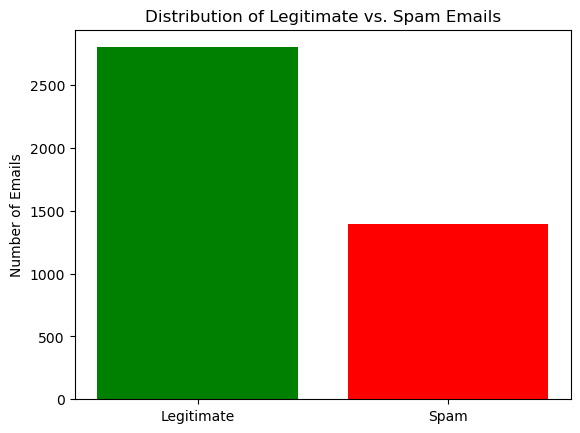

In [18]:
import matplotlib.pyplot as plt

legit_count = len(legitimate)
spam_count = len(spam)

fig, ax = plt.subplots()

ax.bar(["Legitimate", "Spam"], [legit_count, spam_count], color = ["green", "red"])

ax.set_ylabel("Number of Emails")
ax.set_title("Distribution of Legitimate vs. Spam Emails")

plt.show()

In [19]:
# creating labels for spam and legit, where spam is 0 and legitimate is 1
target = np.array(len(legitimate['content']) * [1] + len(spam['content']) * [0])

In [20]:
# taking a look at our target
target[-1], target[0] # our target of 0s and 1s

(0, 1)

In [21]:
# creating the features
features = list(legitimate['content']) + list(spam['content'])

In [22]:
# taking a look at some features
features[0][0:13]

['investor',
 'width',
 'width',
 'width',
 'height',
 'investor',
 'width',
 'width',
 'width',
 'width',
 'width',
 'width',
 'width']

In [23]:
# converting the features and target to numpy arrays and reshaping them
features, target = np.array(features, dtype = object).reshape(-1, 1), np.array(target).reshape(-1, 1)

In [24]:
# using stratified random split to generate training and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, stratify = target, test_size = 0.2, random_state = 0)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 0)

In [25]:
# looking at the shapes
print('X_train: {}, X_test: {}, y_train: {}, y_test: {}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape)) 

X_train: (2520, 1), X_test: (840, 1), y_train: (2520, 1), y_test: (840, 1)


In [26]:
print('X_train: {}, X_test: {}, X_val: {}, y_val: {}'.format(X_train.shape, X_test.shape, X_val.shape, y_val.shape)) 

X_train: (2520, 1), X_test: (840, 1), X_val: (840, 1), y_val: (840, 1)


In [27]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize_data(X_train, X_test, y_train, y_test, X_val, y_val):
    # Convert X_train to a list of strings and convert to lowercase
    X_train = [str(x).lower() for x in X_train]
    
    # Convert X_test to a list of strings and convert to lowercase
    X_test = [str(x).lower() for x in X_test]
    
    # Convert X_val to a list of strings and convert to lowercase
    X_val = [str(x).lower() for x in X_val]
    
    # Initialize CountVectorizer and fit training data
    count_vect = CountVectorizer(stop_words='english')
    count_vect.fit(X_train)

    # Vectorize the training data
    X_train = count_vect.transform(X_train).toarray()
    y_train = np.array(y_train).reshape(len(y_train), 1)

    # Vectorize the testing data
    X_test = count_vect.transform(X_test).toarray()
    y_test = np.array(y_test).reshape(len(y_test), 1)
    
    # Vectorize the validation data
    X_val = count_vect.transform(X_val).toarray()
    y_val = np.array(y_val).reshape(len(y_val), 1)

    return X_train, X_test, y_train, y_test, X_val, y_val

# vectorizing the training, validation, and test sets
X_train_vec, X_test_vec, y_train_vec, y_test_vec, X_val_vec, y_val_vec = vectorize_data(X_train, X_test, y_train, y_test,  X_val, y_val)

In [47]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')


# Initialisieren des Modells
bnb = BernoulliNB()

# Trainieren des Modells
bnb.fit(X_train_vec, y_train_vec)

# Vorhersage auf den Testdaten
y_pred_bnb = bnb.predict(X_test_vec)

# Berechnung der Genauigkeit des Modells
accuracy = accuracy_score(y_test_vec, y_pred_bnb)
print(f"Genauigkeit: {accuracy}")

Genauigkeit: 0.9214285714285714


In [48]:
from sklearn.naive_bayes import ComplementNB
warnings.filterwarnings('ignore')

# Initialize the ComplementNB classifier
cnb = ComplementNB()

# Train the model on the training data
cnb.fit(X_train_vec, y_train_vec)

# Predict the labels of the test data
y_pred_cnb = cnb.predict(X_test_vec)

# Calculate the accuracy score of the model
accuracy = accuracy_score(y_test_vec, y_pred_cnb)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8940476190476191


In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')

# Train the model
mnb = MultinomialNB()

mnb.fit(X_train_vec, y_train_vec)

# Predict the labels of the test data
y_pred_mnb = mnb.predict(X_test_vec)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred_mnb)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9130952380952381


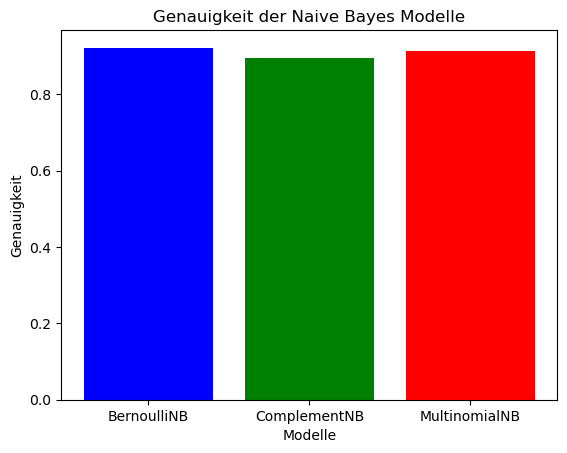

In [45]:
import matplotlib.pyplot as plt

# Genauigkeiten der Modelle
accuracies = [0.9214285714285714, 0.8940476190476191, 0.9130952380952381]

# Modelle
models = ['BernoulliNB', 'ComplementNB', 'MultinomialNB']

# Erstellen des Barplots
plt.bar(models, accuracies, color=['blue', 'green', 'red'])

# Titel und Beschriftungen hinzufügen
plt.title('Genauigkeit der Naive Bayes Modelle')
plt.xlabel('Modelle')
plt.ylabel('Genauigkeit')

# Anzeigen des Plots
plt.show()


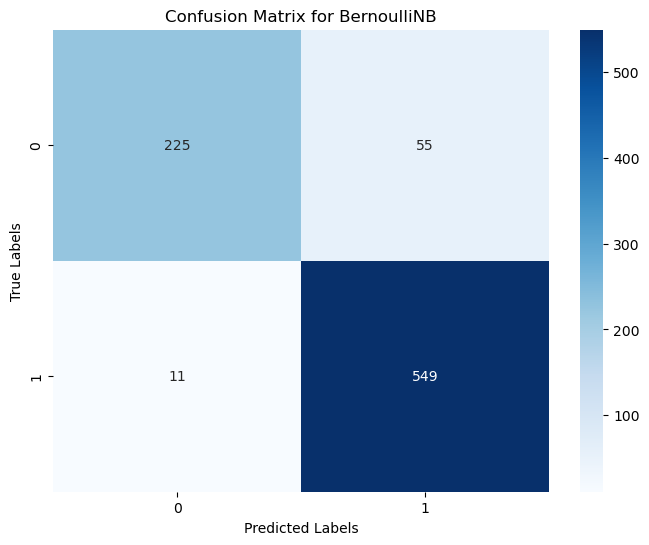

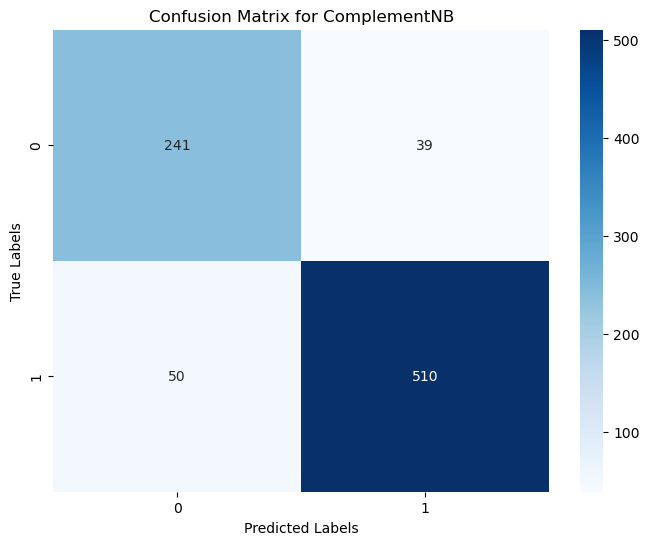

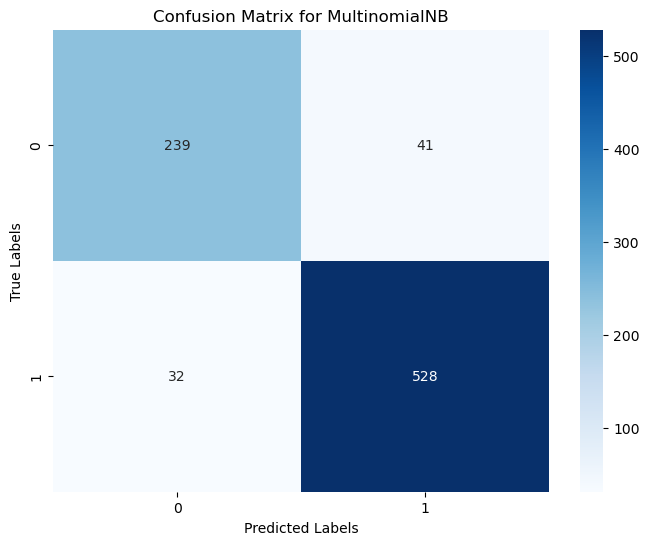

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Modelle und ihre Vorhersagen
models = ['BernoulliNB', 'ComplementNB', 'MultinomialNB']
y_preds = [y_pred_bnb, y_pred_cnb, y_pred_mnb]

# Erstellen und Anzeigen der Konfusionsmatrizen
for model, y_pred in zip(models, y_preds):
    cm = confusion_matrix(y_test_vec, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title(f'Confusion Matrix for {model}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
